## Import libraries

In [1]:
import pandas as pd
import numpy as np
import tweepy
import us
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from adjustText import adjust_text
from datetime import timedelta

## Set library parameters

In [2]:
# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

# Pandas + matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Pyplot options
plt.rcParams.update({'font.size': 16, 'font.sans-serif': 'Arial'})

## Declare global variables

* Strings related to COVID-19 include: `coronavirus`, `covid` and `ncov`, since some of the most popular hashtags related to the pandemic have been `#ncov2019`, `coronavirus` and `covid` (according to a quick spot-check). The keywords `virus` and `cdc` were too general---some health departments were tweeting about flu and other general health recommendations from the CDC in December 2019.
* CDC and WHO are two large healthcare organizations I created a dictionary for

In [3]:
covid_strings = 'coronavirus|covid|ncov'
hc_org_dict = {
    'cdc' : '146569971',
    'who' : '14499829'
}

## Import data

### Tweets

Data downloaded from the `tweets` sheet of `https://corona-tweets.datasettecloud.com` on 2020/04/01 ~10:49 AM PST (after filtering for `created_at` > `2019-12-01`)

In [4]:
tweets_sheet = '../data/source/tweets-20200406-1732PST.csv'
df_tweets = pd.read_csv(tweets_sheet, dtype={'user': object})
df_tweets.head()

/Users/ihwang/.local/share/virtualenvs/covid19-tweets-jKmwAzGh/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,user,user_label,created_at,full_text,retweeted_status,retweeted_status_label,quoted_status,quoted_status_label,place,place_label,source,source_label,truncated,display_text_range,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,geo,coordinates,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,scopes,withheld_in_countries
0,1247314394427482113,236511574,Senator Gary Peters,2020-04-07T00:05:00+00:00,"The bipartisan CARES Act was an important first step, but there is still more work to support Michigan families. \n \n@SenStabenow & I Introduced a bill to make families w/ older children & adult dependents eligible for COVID-19 relief payments. https://twitter.com/SenGaryPeters/status/1247314394427482113/video/1",NaN,NaN,NaN,NaN,NaN,NaN,605db6f136ed878a4ef11d44dbc6b056a17505f3,Twitter Media Studio,0.0,"[0, 251]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,4.0,0.0,0.0,en,0.0,NaN,NaN
1,1247314137266470912,24195214,Jan Schakowsky,2020-04-07T00:03:58+00:00,RT @IRSnews: Thinking about taxes? So are phone scammers! Criminals often pose as #IRS agents and try to steal your money and information.…,1.247313e+18,1.247313e+18,NaN,NaN,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0.0,"[0, 139]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,en,NaN,NaN,NaN
2,1247313969817288712,1075517806551154689,Rep. Veronica Escobar,2020-04-07T00:03:19+00:00,RT @IRSnews: Thinking about taxes? So are phone scammers! Criminals often pose as #IRS agents and try to steal your money and information.…,1.247313e+18,1.247313e+18,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0.0,"[0, 139]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,0.0,0.0,0.0,en,NaN,NaN,NaN
3,1247313933200953344,168502762,Rep. Eddie Bernice Johnson,2020-04-07T00:03:10+00:00,"Today, I along w/53 Members sent a letter to the White House Coronavirus Taskforce to ensure medication access for #lupus and rheumatoid arthritis patients during #COVID19. Thanks @RepMcKinley,@USRepKeating, @RepPeteKing, & @RepDebDingell for partnering on this effort! https://twitter.com/RepEBJ/status/1247313933200953344/photo/1",NaN,NaN,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0.0,"[0, 274]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0,0.0,0.0,en,0.0,NaN,NaN
4,1247313729664008197,24195214,Jan Schakowsky,2020-04-07T00:02:21+00:00,"RT @SenatorDurbin: Glad to see more than 450,000 Illinois households will receive increased SNAP benefits thanks to recent federal legislat…",1.247313e+18,1.247313e+18,NaN,NaN,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0.0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0,0.0,0.0,0.0,en,NaN,NaN,NaN


### The COVID Tracking Project

Get historical state cases data from The COVID Tracking Project (https://covidtracking.com/api/)

In [7]:
df_states_cases = pd.read_json('https://covidtracking.com/api/states/daily')
df_states_cases['dateChecked'] = pd.to_datetime(df_states_cases['dateChecked'])
df_states_cases['date'] = pd.to_datetime(df_states_cases['date'], format='%Y%m%d')
# df_states_cases.head()

### Local government Twitter Handles

Specify variables to download specific sheets from the `Official_twitter_handles` Google Sheet
* Google Sheet: https://docs.google.com/spreadsheets/d/13wRn7ZswD2p180OQY7JiJgv-CHug36CiQqFkhpzQYwY
* GUIDs refer to the IDs of individual sheeets within the document

In [8]:
sheet_key = '13wRn7ZswD2p180OQY7JiJgv-CHug36CiQqFkhpzQYwY'
guid_dict = {
    'Healthcare': 64630233,
    'Governers': 470577166,
    'Congress': 354414704
}
guid = guid_dict['Healthcare']

Import Google Sheet

In [9]:
handles_sheet = 'https://docs.google.com/spreadsheets/d/' + sheet_key + '/export?format=csv&gid=%s' %guid
df_hc_handles = pd.read_csv(handles_sheet)
df_hc_handles.sort_values('Abbreviation')

,State,Abbreviation,State Health Department,Website,Twitter Handle,Covid Page,Covid Twitter Handle
1,Alaska,AK,Alaska Division of Public Health,http://dhss.alaska.gov/dph/Pages/default.aspx,Alaska_DHSS,NaN,NaN
0,Alabama,AL,Alabama Department of Public Health,http://www.alabamapublichealth.gov/,alpublichealth,NaN,NaN
3,Arkansas,AR,Arkansas Department of Health,https://www.healthy.arkansas.gov/,adhpio,NaN,NaN
2,Arizona,AZ,Arizona Department of Health Services,https://www.azdhs.gov/,azdhs,NaN,NaN
4,California,CA,California Department of Public Health,https://www.cdph.ca.gov/,CAPublicHealth,NaN,NaN
5,Colorado,CO,Colorado Department of Public Health and Environment,https://covid19.colorado.gov/,CDPHE,NaN,NaN
6,Connecticut,CT,Connecticut Department of Public Health,https://portal.ct.gov/dph,ctdph,NaN,NaN
8,District of Columbia,DC,District of Columbia Department of Health,https://dchealth.dc.gov/,_DCHealth,NaN,NaN
7,Delaware,DE,Delaware Division of Public Health,https://dhss.delaware.gov/dhss/dph/index.html,Delaware_DHSS,NaN,NaN
9,Florida,FL,Florida Department of Health,http://www.floridahealth.gov/,HealthyFla,NaN,NaN


### Shelter-in-place orders

Specify variables to download specific sheets from the `shelter-in-place` Google Sheet
* Google Sheet: https://docs.google.com/spreadsheets/d/1iOChy4gxV3RUz2uHYRHL5OwSbyIV8p9Jo1tTR-R1-Hw
* GUIDs refer to the IDs of individual sheeets within the document

In [10]:
sheet_key = '1iOChy4gxV3RUz2uHYRHL5OwSbyIV8p9Jo1tTR-R1-Hw'
guid_dict = {
    'States': 0,
    'Cities': 1430032085,
    'Counties': 1083934346
}
guid = guid_dict['States']

Import Google Sheet

In [11]:
handles_sheet = 'https://docs.google.com/spreadsheets/d/' + sheet_key + '/export?format=csv&gid=%s' %guid
df_sip = pd.read_csv(handles_sheet)
df_sip['Date effective'] = pd.to_datetime(df_sip['Date effective'])
df_sip.sort_values('State')

,State,Date effective,Order
0,Alabama,NaT,NaN
1,Alaska,2020-03-28,Stay at home
2,Arizona,2020-03-31,Stay at home
3,Arkansas,NaT,NaN
4,California,2020-03-19,Stay at home
5,Colorado,2020-03-26,Stay at home
6,Connecticut,2020-03-23,Stay at home
7,Delaware,2020-03-24,Shelter in place
8,District of Columbia,2020-04-01,Stay at home
9,Florida,2020-04-03,Stay at home


### Twitter API

Read in Twitter credentials from .env file

In [12]:
twitter_creds = '../.env'

with open(twitter_creds) as f:
    for line in f:
        line_contents = line.strip().split('=')
        if line_contents[0] == 'CONSUMER_KEY':
            consumer_key = line_contents[1]
        elif line_contents[0] == 'CONSUMER_SECRET_KEY':
            consumer_secret = line_contents[1]
        elif line_contents[0] == 'ACCESS_TOKEN':
            access_token = line_contents[1]
        elif line_contents[0] == 'ACCESS_TOKEN_SECRET':
            access_token_secret = line_contents[1]
        else:
            pass

Access Twitter API

In [13]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

Get Twitter user IDs from handles

In [14]:
user_ids = [str(api.get_user(screen_name).id) for screen_name in df_hc_handles['Twitter Handle']]

## Process raw data

Add Twitter user IDs to `df_handles` dataframe

In [15]:
df_hc_handles['user_id'] = user_ids

Create `df_hc_tweets` dataframe and do some basic cleaning up on it.

In [16]:
# Join df_tweets and df_hc_handles to get dataframe of tweets from Healthcare agencies
df_hc_tweets = pd.merge(
    df_tweets, df_hc_handles, left_on='user', right_on='user_id', how='inner', sort=False
)
# Transform created_at column from Timestamp to DateTime object
df_hc_tweets['created_at'] = pd.to_datetime(df_hc_tweets['created_at'])
len(df_hc_tweets)

19268

Sanity check: how many healthcare agencies have tweeted?

In [17]:
len(df_hc_tweets['user'].unique())

49

That's odd...because there are 50 states, plus DC, totaling 51. Check number of healthcare handles.

In [18]:
len(df_hc_handles.index)

51

As expected, 51 healthcare handles. Okay, clearly Tweets from some state healthcare accounts are missing from the joined dataframe of healthcare tweets. Which ones?

In [19]:
missing_users = set(df_hc_handles['user_id']).difference(set(df_hc_tweets['user']))
for missing_user in missing_users:
    print(missing_user, api.get_user(missing_user).screen_name)

2885836175 MaineDHHS
1019591965766119425 health_wyoming


Extract tweets from health departments mentioning COVID-19

In [20]:
# Filter for keywords coronavirus and covid (not case-sensitive)
df_hc_covid_tweets = df_hc_tweets[df_hc_tweets['full_text'].\
                                  str.contains(covid_strings, regex=True, case=False)]

# df_hc_covid_tweets.head()
df_hc_covid_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9402 entries, 0 to 19264
Data columns (total 38 columns):
id                         9402 non-null object
user                       9402 non-null object
user_label                 9402 non-null object
created_at                 9402 non-null datetime64[ns, UTC]
full_text                  9402 non-null object
retweeted_status           2715 non-null float64
retweeted_status_label     2715 non-null float64
quoted_status              297 non-null float64
quoted_status_label        297 non-null float64
place                      58 non-null object
place_label                58 non-null object
source                     9402 non-null object
source_label               9402 non-null object
truncated                  9402 non-null float64
display_text_range         9402 non-null object
in_reply_to_status_id      1220 non-null float64
in_reply_to_user_id        1282 non-null float64
in_reply_to_screen_name    1282 non-null object
geo           

## Basic questions

How much has each agency tweeted?

In [39]:
df_hc_covid_tweets['State Health Department'].value_counts().sort_values(ascending=False)

Washington Department of Health                           612
North Carolina Department of Health and Human Services    562
Ohio Department of Health                                 535
Pennsylvania Department of Health                         414
Massachusetts Department of Public Health                 412
California Department of Public Health                    336
Alabama Department of Public Health                       317
New Jersey Department of Health                           291
Rhode Island Department of Health                         277
Oregon Health Authority                                   268
Indiana Department of Health                              256
Illinois Department of Public Health                      250
Colorado Department of Public Health and Environment      239
New Mexico Department of Health                           237
Minnesota Department of Health                            237
Tennessee Department of Health                            228
Florida 

Spot-check certain departments

In [22]:
dept = 'Utah Department of Health'
df_hc_handles[df_hc_handles['State Health Department'] == dept]

,State,Abbreviation,State Health Department,Website,Twitter Handle,Covid Page,Covid Twitter Handle,user_id
44,Utah,UT,Utah Department of Health,https://health.utah.gov/,UtahDepOfHealth,NaN,NaN,36099461


In [23]:
# df_hc_tweets[df_hc_tweets['user']=='3996166572'].sort_values('created_at',ascending=False)

When did healthcare departments start tweeting?

In [24]:
df_hc_covid_tweets.groupby(['State Health Department','Abbreviation'])['created_at'].min().sort_values(ascending=True)

State Health Department                                 Abbreviation
New Jersey Department of Health                         NJ             2020-02-04 19:39:25+00:00
Washington Department of Health                         WA             2020-02-04 20:13:01+00:00
Wisconsin Department of Health Services                 WI             2020-02-04 20:30:00+00:00
California Department of Public Health                  CA             2020-02-04 21:34:17+00:00
Rhode Island Department of Health                       RI             2020-02-04 22:25:10+00:00
Oregon Health Authority                                 OR             2020-02-04 23:21:27+00:00
New Hampshire Department of Health and Human Services   NH             2020-02-05 02:36:51+00:00
Hawaii Department of Health                             HI             2020-02-05 02:48:45+00:00
Ohio Department of Health                               OH             2020-02-05 13:40:22+00:00
Alabama Department of Public Health                     AL

In [25]:
df_first_tweets = df_hc_covid_tweets.groupby(['State Health Department','Abbreviation'])['created_at'].min().sort_values(ascending=True).reset_index()
df_first_tweets.to_csv('../data/source/first-tweets.csv')

Select a state health department and display tweets in chronological order

In [41]:
dept = 'Georgia Department of Public Health'
df_hc_covid_tweets[df_hc_covid_tweets['State Health Department'] == dept].sort_values('created_at')
# df_hc_tweets[df_hc_tweets['State Health Department'] == dept].sort_values('created_at')

,id,user,user_label,created_at,full_text,retweeted_status,retweeted_status_label,quoted_status,quoted_status_label,place,place_label,source,source_label,truncated,display_text_range,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,geo,coordinates,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,scopes,withheld_in_countries,State,Abbreviation,State Health Department,Website,Twitter Handle,Covid Page,Covid Twitter Handle,user_id
13050,1232424561804763143,325113018,GaDeptPublicHealth,2020-02-25 21:58:07+00:00,RT @NGAHealthDist: #CDC and public health authorities have implemented aggressive measures to slow and contain transmission of #COVIDー19 in…,1.232423e+18,1.232423e+18,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.0,0.0,0.0,0.0,en,NaN,NaN,NaN,Georgia,GA,Georgia Department of Public Health,https://dph.georgia.gov/,GaDPH,NaN,NaN,325113018
13049,1232783134242082816,325113018,GaDeptPublicHealth,2020-02-26 21:42:57+00:00,"The Georgia Department of Public Health (DPH) is working closely with the #CDC, and state partners to prepare for a potential outbreak of #COVID-19 in the U.S., including Georgia. Read more: http://bit.ly/386J2qB https://twitter.com/GaDPH/status/1232783134242082816/photo/1",NaN,NaN,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 214]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,23.0,23.0,0.0,0.0,en,0.0,NaN,NaN,Georgia,GA,Georgia Department of Public Health,https://dph.georgia.gov/,GaDPH,NaN,NaN,325113018
13048,1233801619256619014,325113018,GaDeptPublicHealth,2020-02-29 17:10:03+00:00,"RT @CDCgov: To protect yourself from #COVID19, avoid being exposed to the virus and use everyday prevention action to prevent the spread of…",1.233491e+18,1.233491e+18,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,1696.0,0.0,0.0,0.0,en,NaN,NaN,NaN,Georgia,GA,Georgia Department of Public Health,https://dph.georgia.gov/,GaDPH,NaN,NaN,325113018
13047,1233801820490825729,325113018,GaDeptPublicHealth,2020-02-29 17:10:51+00:00,"RT @GovKemp: Today we announced the state’s #Coronavirus Task Force and held its first meeting. We have no confirmed cases in Georgia, but…",1.233535e+18,1.233535e+18,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 139]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,52.0,0.0,0.0,0.0,en,NaN,NaN,NaN,Georgia,GA,Georgia Department of Public Health,https://dph.georgia.gov/,GaDPH,NaN,NaN,325113018
13044,1234690115521458176,325113018,GaDeptPublicHealth,2020-03-03 04:00:37+00:00,DPH has confirmed Georgia’s first cases of #COVID19 involving two residents of Fulton County who live in the same household. Both have mild symptoms and are isolated at home. Read more: https://bit.ly/2VCVhsr https://twitter.com/GaDPH/status/1234690115521458176/photo/1,NaN,NaN,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 209]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,58.0,42.0,0.0,0.0,en,0.0,NaN,NaN,Georgia,GA,Georgia Department of Public Health,https://dph.georgia.gov/,GaDPH,NaN,NaN,325113018
13043,1234691812985573376,325113018,GaDeptPublicHealth,2020-03-03 04:07:22+00:00,"During this time, it’s important to stay informed and remain calm. The same measures that are urged for preventing any respiratory virus are encouraged for preventing #COVID19. For recent information about #COVID19 in GA, visit: http://dph.georgia.gov and http://www.cdc.gov/coronavirus/2019-ncov https://twitter.com/GaDPH/status/1234691812985573376/photo/1",NaN,NaN,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 280]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,55.0,42.0,0.0,0.0,en,0.0,NaN,NaN,Georgia,GA,Georgia Department of Public Health,https://dph.georgia.gov/,GaDPH,NaN,NaN,325113018
13039,1235592031688409092,325113018,GaDeptPublicHealth,2020-03-05 15:44:31+00:00,"RT @CDCgov: As more cases of #COVID

In [27]:
# dept = 'cdc'
# df_tweets[df_tweets['user'] == hc_org_dict[dept]].sort_values('created_at')

## Visualizations

Plot cumulative number of Tweets about COVID-19, positive cases, hospitalizations and deaths over time

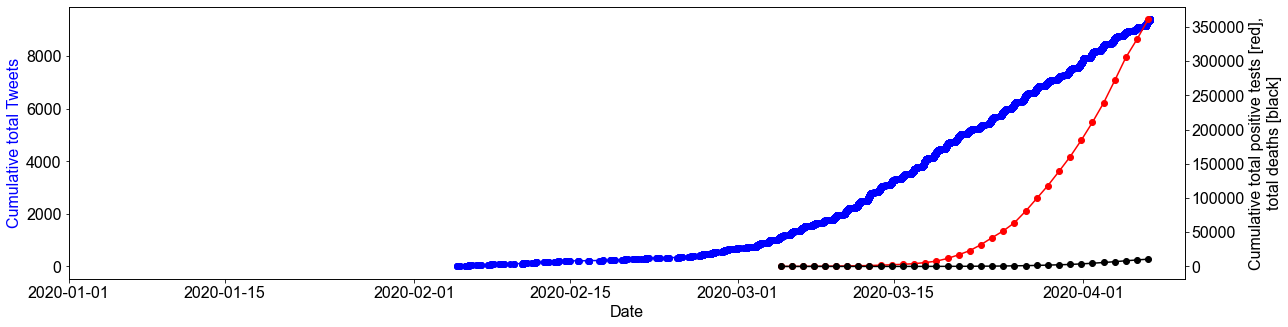

In [28]:
# Define df
df_plot = df_hc_covid_tweets.sort_values('created_at').reset_index()
series_pos = df_states_cases.groupby('dateChecked')['positive'].sum()
series_deaths = df_states_cases.groupby('dateChecked')['death'].sum()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()

axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue')
axes2.plot(series_pos.index, series_pos, 'o-', color='red')
axes2.plot(series_deaths.index, series_deaths, 'o-', color='black')

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_ylabel('Cumulative total Tweets', color='blue')
axes2.set_ylabel('Cumulative total positive tests [red],\ntotal deaths [black]')
axes.set_xlabel('Date')
plt.show()

Show total Tweets and Tweets for each state

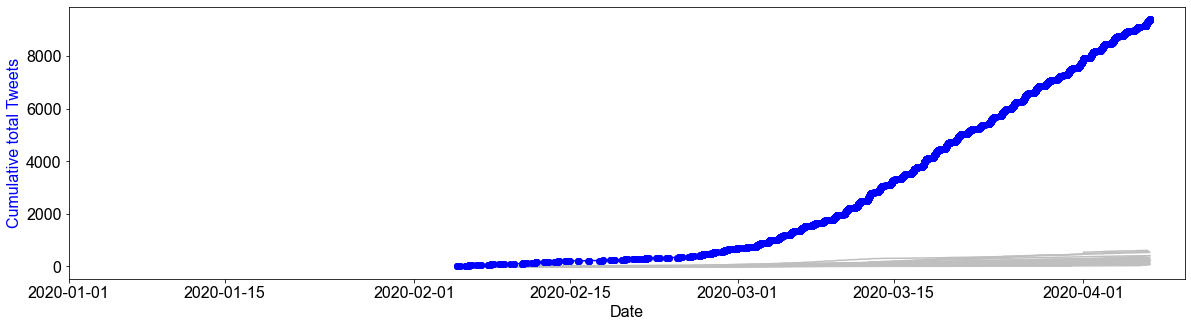

In [29]:
# Define df
df_plot = df_hc_covid_tweets.sort_values('created_at').reset_index()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))

state_depts = df_hc_covid_tweets['State Health Department'].unique()

for state in state_depts:
    df_state = df_hc_covid_tweets[df_hc_covid_tweets['State Health Department'] == state]
    df_state = df_state.sort_values('created_at').reset_index()
    axes.plot(df_state['created_at'], df_state.index, '-', color='0.75')
axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue')

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_ylabel('Cumulative total Tweets', color='blue')
axes.set_xlabel('Date')
plt.show()

It's hard to tell with total Tweets, so let's plot just individual states, with the ability to highlight one state of interest

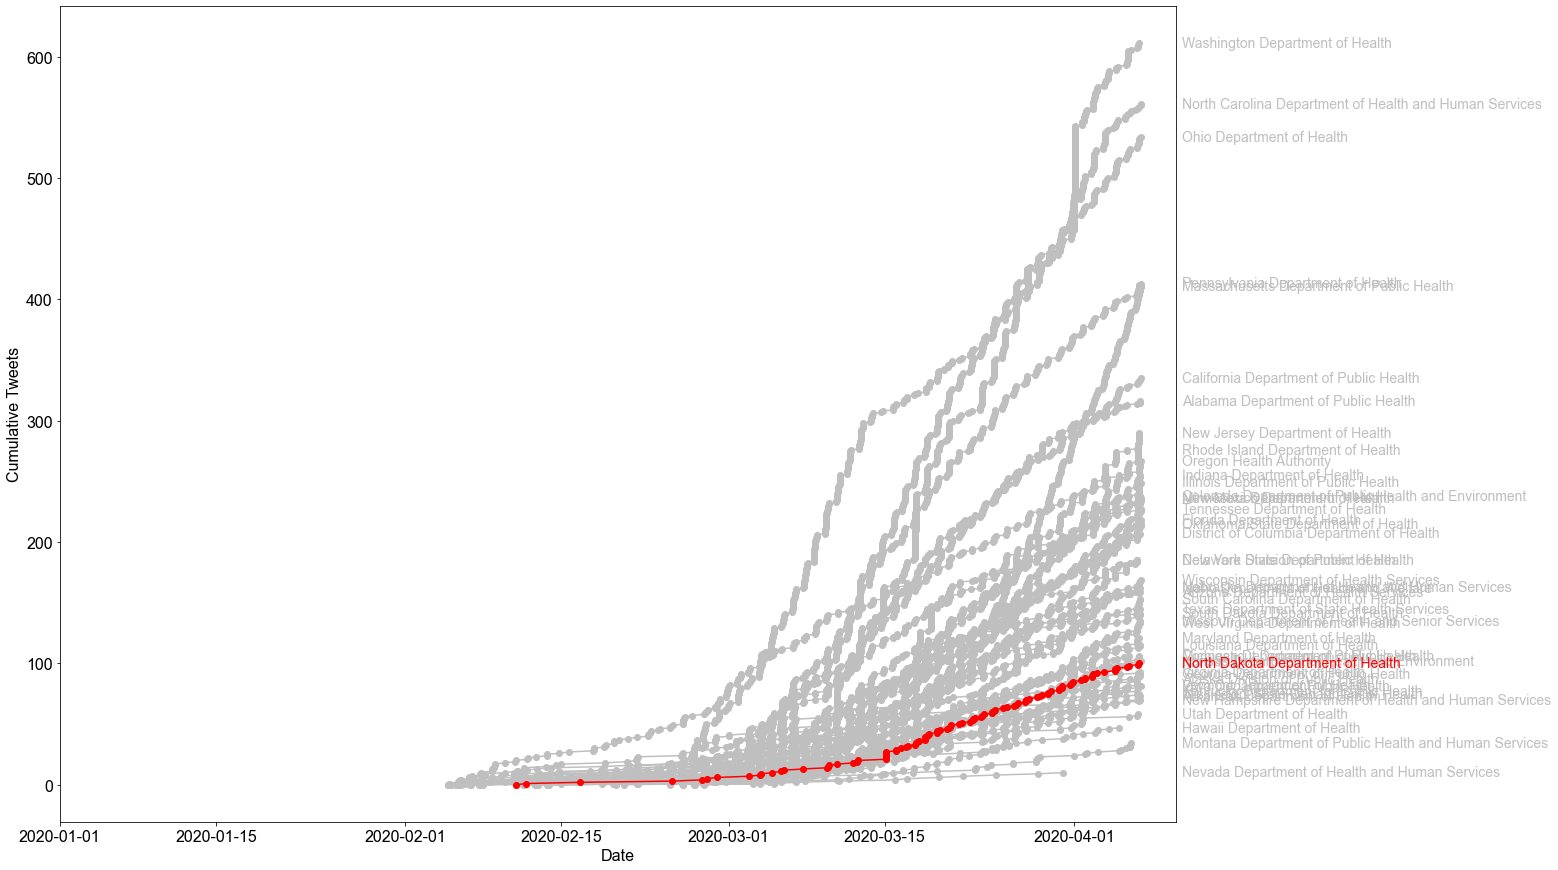

In [30]:
state = 'ND'
dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Department'].iloc[0]

# Define df
df_plot = df_hc_covid_tweets.sort_values('created_at').reset_index()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 15))

state_depts = df_hc_covid_tweets['State Health Department'].unique()
state_depts = np.append(np.delete(state_depts, np.argwhere(state_depts==dept)[0][0]), dept)

for state_dept in state_depts:
    df_state = df_hc_covid_tweets[df_hc_covid_tweets['State Health Department'] == state_dept]
    df_state = df_state.sort_values('created_at').reset_index()
    if state_dept == dept:
        color = 'red'
    else:
        color = '0.75'
    axes.plot(df_state['created_at'], df_state.index, 'o-', color=color)

for line, name in zip(axes.lines, state_depts):
    y = line.get_ydata()[-1]
    if name == dept:
        color = 'red'
    else:
        color = '0.75'
    axes.annotate(name, xy=(1,y), xytext=(6,0), color=color,
                xycoords = axes.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_ylabel('Cumulative Tweets')
axes.set_xlabel('Date')
plt.show()

What do COVID-19 tweets look like in comparison to the account normal tweets?

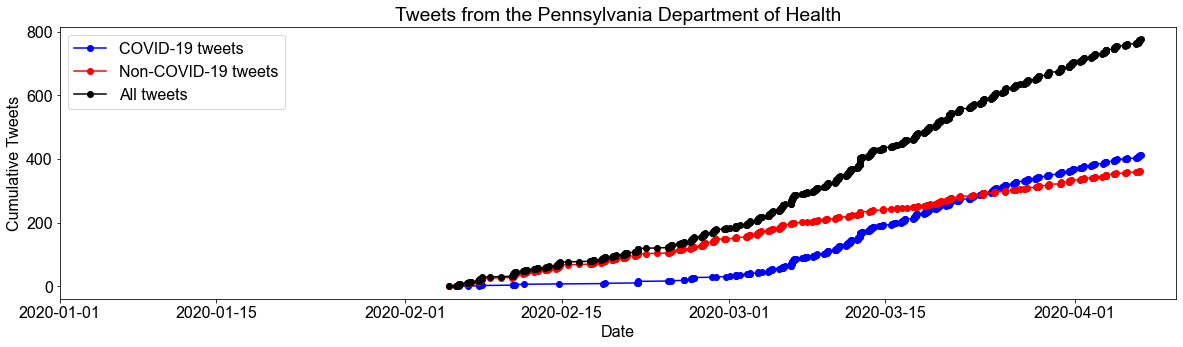

In [31]:
state = 'PA'

state_name = us.states.lookup(state).name
dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Department'].iloc[0]
sip_date = df_sip[df_sip['State'] == state_name]['Date effective'].iloc[0]

# Define df
df_plot = df_hc_covid_tweets[df_hc_covid_tweets['State Health Department'] == dept]
df_plot = df_plot.sort_values('created_at').reset_index()
df_plot2 = df_hc_tweets[
    (df_hc_tweets['State Health Department'] == dept) & 
    ~(df_hc_tweets['full_text'].str.contains(covid_strings, regex=True, case=False))
]
df_plot2 = df_plot2.sort_values('created_at').reset_index()
df_plot3 = df_hc_tweets[df_hc_tweets['State Health Department'] == dept]
df_plot3 = df_plot3.sort_values('created_at').reset_index()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))

axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue', label='COVID-19 tweets')
axes.plot(df_plot2['created_at'], df_plot2.index, 'o-', color='red', label='Non-COVID-19 tweets')
axes.plot(df_plot3['created_at'], df_plot3.index, 'o-', color='black', label='All tweets')

if pd.notnull(sip_date):
    sip_order = df_sip[df_sip['State'] == state_name]['Order'].iloc[0]
    axes.axvline(x=mdates.date2num(sip_date), linestyle='--', color='grey')
    axes.annotate(sip_order + ' instated', (mdates.date2num(sip_date), .9*max(df_plot3.index)), xytext=(-220,0), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_title('Tweets from the %s' %dept)
axes.set_ylabel('Cumulative Tweets')
axes.set_xlabel('Date')
axes.legend(loc='upper left')
plt.show()

In [32]:
df_plot2

,index,id,user,user_label,created_at,full_text,retweeted_status,retweeted_status_label,quoted_status,quoted_status_label,place,place_label,source,source_label,truncated,display_text_range,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,geo,coordinates,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,scopes,withheld_in_countries,State,Abbreviation,State Health Department,Website,Twitter Handle,Covid Page,Covid Twitter Handle,user_id
0,2666,1224799789725843457,3218464527,PA Department of Health,2020-02-04 21:00:00+00:00,Tobacco use increases your risk for heart disease + heart attack. Help your ❤️ stay healthy by quitting tobacco for good. \n☎️ call 1-800-QUIT-NOW\n📱 text QUIT to 47848 \n🖥️ visit http://smokefree.gov \n#heartmonth https://twitter.com/PAHealthDept/status/1224799789725843457/photo/1,NaN,NaN,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0.0,"[0, 213]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,2.0,0.0,0.0,en,0.0,NaN,NaN,Pennsylvania,PA,Pennsylvania Department of Health,https://www.health.pa.gov/Pages/default.aspx,PAHealthDept,NaN,NaN,3218464527
1,2665,1225041384912183296,3218464527,PA Department of Health,2020-02-05 13:00:00+00:00,Q: What does U=U mean? \n\nA: U=U means that a person with HIV who takes treatment as prescribed + has an undetectable viral load CANNOT transmit HIV. Undetectable = Untransmittable. \n\nLearn more about #UequalsU → http://bit.ly/2TeuKic https://twitter.com/PAHealthDept/status/1225041384912183296/photo/1,NaN,NaN,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0.0,"[0, 235]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,6.0,0.0,0.0,en,0.0,NaN,NaN,Pennsylvania,PA,Pennsylvania Department of Health,https://www.health.pa.gov/Pages/default.aspx,PAHealthDept,NaN,NaN,3218464527
2,2664,1225071582655045640,3218464527,PA Department of Health,2020-02-05 15:00:00+00:00,#Heartdisease can often be 𝙥𝙧𝙚𝙫𝙚𝙣𝙩𝙚𝙙 when people make healthy lifestyle choices! Learn how you can keep your heart healthy: http://bit.ly/2HCt1Rl #heartmonth https://twitter.com/PAHealthDept/status/1225071582655045640/photo/1,NaN,NaN,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0.0,"[0, 159]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,1.0,0.0,0.0,en,0.0,NaN,NaN,Pennsylvania,PA,Pennsylvania Department of Health,https://www.health.pa.gov/Pages/default.aspx,PAHealthDept,NaN,NaN,3218464527
3,2663,1225103252942925832,3218464527,PA Department of Health,2020-02-05 17:05:51+00:00,"The #flu can make even normally healthy children 𝙫𝙚𝙧𝙮 sick. If your child is sick + experiencing these emergency warning signs, go to the emergency room ASAP ⤵️ https://twitter.com/PAHealthDept/status/1225103252942925832/photo/1",NaN,NaN,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0.0,"[0, 160]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,en,0.0,NaN,NaN,Pennsylvania,PA,Pennsylvania Department of Health,https://www.health.pa.gov/Pages/default.aspx,PAHealthDept,NaN,NaN,3218464527
4,2661,1225131981366755329,3218464527,PA Department of Health,2020-02-05 19:00:00+00:00,No soap + water? You can still get clean hands by using hand sanitizer! Carry a bottle in your bag or car so you always have it available. https://twitter.com/PAHealthDept/status/1225131981366755329/photo/1,NaN,NaN,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0.0,"[0, 138]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0,0.0,0.0,en,0.0,NaN,NaN,Pennsylvania,PA,Pennsylvania Department of Health,https://www.health.pa.gov/Pages/default.aspx,PAHealthDept,NaN,NaN,3218464527
5,2660,1225138607918387200,3218464527,PA Department of Health,2020-02-05 19:26:20+00:00,RT @HHSGov: February is Teen Dating Violence Awareness Month. @OPRE_ACF works with @ACFHHS program office partners to improve understanding…,1.225129e+18,1.225129e+18,NaN,NaN,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0.0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,17.0,0.0,0.0,0.0,en,NaN,NaN,NaN,Pennsylvania,PA,P

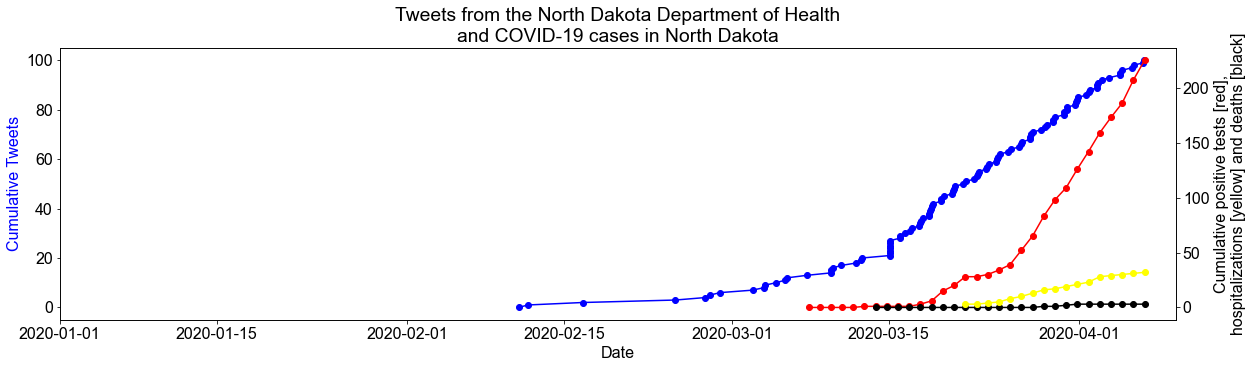

In [33]:
state = 'ND'

state_name = us.states.lookup(state).name
dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Department'].iloc[0]
sip_date = df_sip[df_sip['State'] == state_name]['Date effective'].iloc[0]

# Define df
df_plot = df_hc_covid_tweets[df_hc_covid_tweets['State Health Department'] == dept]
df_plot = df_plot.sort_values('created_at').reset_index()
df_state = df_states_cases[df_states_cases['state'] == state]

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()

axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue')
axes2.plot(df_state['dateChecked'], df_state['positive'], 'o-', color='red')
axes2.plot(df_state['dateChecked'], df_state['death'], 'o-', color='black')
axes2.plot(df_state['dateChecked'], df_state['hospitalized'], 'o-', color='yellow')

if pd.notnull(sip_date):
    sip_order = df_sip[df_sip['State'] == state_name]['Order'].iloc[0]
    axes.axvline(x=mdates.date2num(sip_date), linestyle='--', color='grey')
    axes.annotate(sip_order + ' instated', (mdates.date2num(sip_date), .9*max(df_plot.index)), xytext=(-220,0), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_title('COVID-19 Tweets from the %s\nand COVID-19 cases in %s' %(dept, us.states.lookup(state).name))
axes.set_ylabel('Cumulative Tweets', color='blue')
axes2.set_ylabel('Cumulative positive tests [red],\nhospitalizations [yellow] and deaths [black]')
axes.set_xlabel('Date')
plt.show()

In [34]:
df_plot

,index,id,user,user_label,created_at,full_text,retweeted_status,retweeted_status_label,quoted_status,quoted_status_label,place,place_label,source,source_label,truncated,display_text_range,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,geo,coordinates,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,scopes,withheld_in_countries,State,Abbreviation,State Health Department,Website,Twitter Handle,Covid Page,Covid Twitter Handle,user_id
0,16664,1227002200133636096,815379032,ND Department of Health,2020-02-10 22:51:35+00:00,"2019-nCoV UPDATE: Michelle Dethloff from the NDDoH Division of Disease Control provides an update on the Novel Coronavirus, the state-level response and prevention tools for you! https://twitter.com/NDDOH/status/1227002200133636096/video/1",NaN,NaN,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 178]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,2.0,0.0,0.0,en,0.0,NaN,NaN,North Dakota,ND,North Dakota Department of Health,https://www.health.nd.gov/,NDDOH,NaN,NaN,815379032
1,16662,1227305610636660737,815379032,ND Department of Health,2020-02-11 18:57:14+00:00,We're monitoring 3 individuals with a travel history to #China and are monitoring them daily for symptoms. There are currently no cases of #coronavirus in ND and no persons under investigation. Find more information at http://health.nd.gov/coronavirus. #nCoV #Travel #Monitor https://twitter.com/NDDOH/status/1227305610636660737/photo/1,NaN,NaN,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 266]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,1.0,0.0,0.0,en,0.0,NaN,NaN,North Dakota,ND,North Dakota Department of Health,https://www.health.nd.gov/,NDDOH,NaN,NaN,815379032
2,16656,1229081327741423616,815379032,ND Department of Health,2020-02-16 16:33:18+00:00,"Weekly COVID-19 Update: Michelle Dethloff from the NDDoH Division of Disease Control provides your update on the novel coronavirus, now known as COVID-19. Find the latest numbers at http://health.nd.gov/coronavirus https://twitter.com/NDDOH/status/1229081327741423616/video/1",NaN,NaN,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 205]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0,0.0,0.0,en,0.0,NaN,NaN,North Dakota,ND,North Dakota Department of Health,https://www.health.nd.gov/,NDDOH,NaN,NaN,815379032
3,16651,1232076000197931008,815379032,ND Department of Health,2020-02-24 22:53:03+00:00,"COVID-19 UPDATE: Michelle Dethloff from the NDDoH Division of Disease Control has your weekly novel coronavirus update, including CDC-issued travel advisories and the number of North Dakotans currently under monitoring for COVID-19. ND still has zero suspected or confirmed cases. https://twitter.com/NDDOH/status/1232076000197931008/video/1",NaN,NaN,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 280]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,2.0,0.0,0.0,en,0.0,NaN,NaN,North Dakota,ND,North Dakota Department of Health,https://www.health.nd.gov/,NDDOH,NaN,NaN,815379032
4,16648,1233040258280890377,815379032,ND Department of Health,2020-02-27 14:44:41+00:00,"A great reminder that while COVID-19 should be taken seriously, influenza is also impacting our country in huge ways. Get the flu vaccine, avoid sick people and wash your hands frequently - it's as simple as that. #HealthyND #COVID #FluFight https://twitter.com/NDDOH/status/1233040258280890377/photo/1",NaN,NaN,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 242]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,2.0,0.0,0.0,en,0.0,NaN,NaN,North Dakota,ND,North Dakota Department of Health,https://www.health.nd.gov/,NDDOH,NaN,NaN,815379032
5,16647,1233193547790196736,815379032,ND Department of Health,2020-02-28 00:53:48+00:00,COVID-19 Update: Michelle Dethloff from the Division of Disease Control brings you an update on the latest developments on #coronavirus in the USA and the CDC's latest worldwide travel

Get a feel for engagement with and by the account:
* Engagement by the account: total number of Tweets that are retweets or quotes
* Engagement with the account: total retweets of this acccount's Tweets

Top accounts this account engaged with?

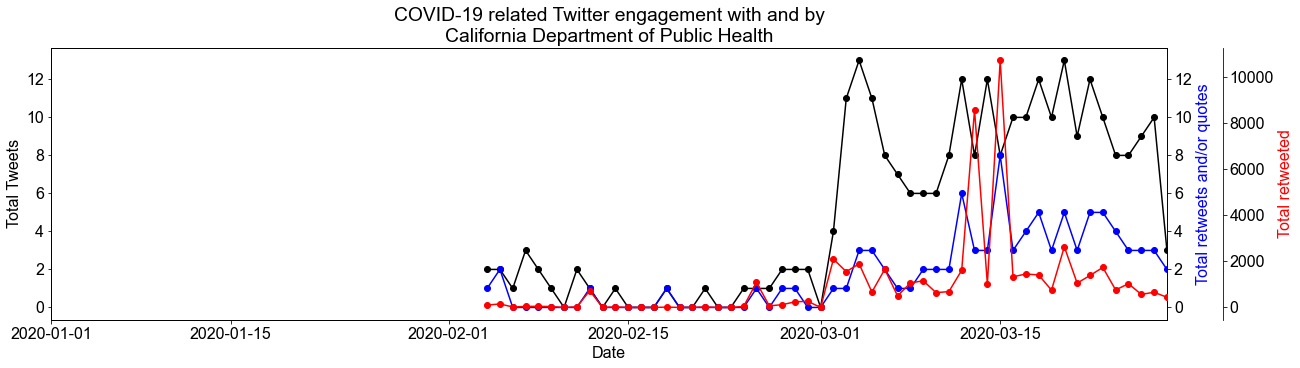

In [38]:
state = 'CA'

dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Department'].iloc[0]

# Define df
df_plot = df_hc_covid_tweets[df_hc_covid_tweets['State Health Department'] == dept]
df_total = df_plot[['created_at']].resample('D', on='created_at').count()
df_engaged_with_counts = df_plot[['created_at', 'retweeted_status', 'quoted_status']].resample('D', on='created_at').count()
series_engaged_with = df_engaged_with_counts.drop(columns=['created_at']).sum(axis=1)
df_engaged_by = df_plot[['created_at', 'retweet_count']].resample('D', on='created_at').sum()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()
axes3 = axes.twinx()
rspine = axes3.spines['right']
rspine.set_position(('axes', 1.05))

axes.plot(df_total.index, df_total, 'o-', color='black')
axes2.plot(series_engaged_with.index, series_engaged_with, 'o-', color='blue')
axes3.plot(df_engaged_by.index, df_engaged_by['retweet_count'], 'o-', color='red')

axes.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-03-28'))
axes2.set_ylim(axes.get_ylim())
axes.set_title('COVID-19 related Twitter engagement with and by\n%s' %dept)
axes.set_ylabel('Total Tweets', color='black')
axes2.set_ylabel('Total retweets and/or quotes', color='blue')
axes3.set_ylabel('Total retweeted', color='red')
axes.set_xlabel('Date')
plt.show()

* test results?